<a href="https://colab.research.google.com/github/Jems-Chawin/Machine-Learning-Lab/blob/main/Lab5/Lab5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB 5 - PART 1 Classification model (NN,CNN,LSTM) with Time Series Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, MaxPooling2D, Flatten, Dense, Dropout

import glob
from scipy import stats
import datetime as dt
from tqdm import tqdm
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


### **Data Preparation**

**Load csv from txt files**

**- Load Acceleration**

In [ ]:
# Get filename of Acceleration

### START CODE HERE ###
fnames = glob.glob("/content/drive/MyDrive/Mini_Set/*_acceleration.txt")

# Read CSV files
testers = []
for f in tqdm(fnames):
    tester = pd.read_csv(f, sep="\s+", header=None, names=['timedelta', 'accX', 'accY', 'accZ'])
    testers.append(tester)

ACC = pd.concat(testers, ignore_index=True)

### END CODE HERE ###

100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


In [ ]:
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
5192995,28828.068306,0.509995,0.462479,-0.559250
5192996,28828.089226,0.465301,0.612167,-0.612411
5192997,28828.109608,0.429871,0.622650,-0.694794
5192998,28828.128373,0.506653,0.607361,-0.815720


**- Load Heart Rate**

In [ ]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("/content/drive/MyDrive/Mini_Set/*_heartrate.txt")

testers = []
for f in tqdm(fnames):
  tester = pd.read_csv(f, sep=",", header=None, names=['timedelta','heartrate'])
  testers.append(tester)

HeartR = pd.concat(testers)

### END CODE HERE ###

100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


In [ ]:
HeartR

,timedelta,heartrate
0,-573407.48573,74.0
1,-573167.65452,78.0
2,-572872.36932,58.0
3,-572374.58424,68.0
4,-572077.08427,76.0
...,...,...
7151,28831.97095,80.0
7152,28840.97095,81.0
7153,28842.97095,80.0
7154,28852.97092,82.0


**- Load Labeled Sleep**

In [ ]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("/content/drive/MyDrive/Mini_Set/*_labeled_sleep.txt")

testers = []
for f in fnames:
  tester = pd.read_csv(f, sep="\s+", header=None, names=['timedelta','sleep'])
  testers.append(tester)


SleepL = pd.concat(testers)

### END CODE HERE ###

**- If some Sleep levels are negative (-1) -> SleepL += 1**

In [ ]:
SleepL.sleep = [0 if each < 0 else each for each in SleepL.sleep]

In [ ]:
SleepL

,timedelta,sleep
0,0,0
1,30,0
2,60,0
3,90,0
4,120,0
...,...,...
944,28320,0
945,28350,0
946,28380,0
947,28410,0


**Synchronizes 'ACC', 'HeartR', 'SleepL'** by aligning their time ranges, <br>
and then filters each dataset to only include data within the overlapping time range.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

<br> ACC start: -124489.16105       ACC end: 37458.8583889
<br> HeartR start: -604720.29398    HeartR end: 37541.70998
<br> SleepL start: 0                SleepL end: 29400


In [ ]:
### START CODE HERE ###

# Find max, min timedelta to find intersection time
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

# Find the common time range
start_time = max(ACC_min_date, HeartR_min_date, SleepL_min_date)
end_time = min(ACC_max_date, HeartR_max_date, SleepL_max_date)

# Obtain data for ACC, HeartR, and SleepL exclusively during the intersection period
ACC = ACC[(ACC['timedelta'] >= start_time) & (ACC['timedelta'] <= end_time)]
HeartR = HeartR[(HeartR['timedelta'] >= start_time) & (HeartR['timedelta'] <= end_time)]
SleepL = SleepL[(SleepL['timedelta'] >= start_time) & (SleepL['timedelta'] <= end_time)]

### END CODE HERE ###

If your code is correct, this cell will execute without any issues.

In [ ]:
print(ACC.shape)
print(HeartR.shape)
print(SleepL.shape)
assert ACC.shape == (4863482, 4)
assert HeartR.shape == (28655, 2)
assert SleepL.shape == (2972, 2)

(4863482, 4)
(28655, 2)
(2972, 2)


Converts the `'timedelta'` column of the `ACC` DataFrame to a `pandas Timedelta object` in seconds and rounds it to the nearest second.

In [ ]:
### START CODE HERE ###
timedelta_unit = 's'  # Define the timedelta_unit variable
resample_rule = '1s'
ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC['timedelta'], timedelta_unit).round(resample_rule))
### END CODE HERE ###
ACC

<ipython-input-12-3b731e672703>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC['timedelta'], timedelta_unit).round(resample_rule))


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
5192995,0 days 08:00:28,0.509995,0.462479,-0.559250
5192996,0 days 08:00:28,0.465301,0.612167,-0.612411
5192997,0 days 08:00:28,0.429871,0.622650,-0.694794
5192998,0 days 08:00:28,0.506653,0.607361,-0.815720


Groups the `ACC` DataFrame by `'timedelta'`, calculates the mean of `'accX', 'accY', and 'accZ'` for each group, and then concatenates these averages into a new DataFrame.

In [ ]:
### START CODE HERE ###
df_acc = ACC.groupby('timedelta').mean().reset_index()
ACC = df_acc
### END CODE HERE ###
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.143596,0.434711,-0.558406
1,0 days 00:00:01,-0.184721,0.438487,-0.492099
2,0 days 00:00:02,-0.213871,0.403676,-0.476563
3,0 days 00:00:03,-0.176616,0.391760,-0.571252
4,0 days 00:00:04,0.072789,0.338097,-0.571049
...,...,...,...,...
29396,0 days 08:09:56,-0.323531,-0.083234,-0.941430
29397,0 days 08:09:57,-0.326982,-0.089659,-0.939489
29398,0 days 08:09:58,-0.327790,-0.093318,-0.939144
29399,0 days 08:09:59,-0.327056,-0.084611,-0.940146


Converts the `'timedelta'` column of the `HeartR` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [ ]:
### START CODE HERE ###
HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR['timedelta'], timedelta_unit).round(resample_rule))
HeartR = HeartR.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
HeartR

<ipython-input-14-76f049911287>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR['timedelta'], timedelta_unit).round(resample_rule))


,heartrate
timedelta,
0 days 00:00:02,65.0
0 days 00:00:03,65.0
0 days 00:00:04,65.0
0 days 00:00:05,65.0
0 days 00:00:06,65.0
...,...
0 days 08:09:55,50.0
0 days 08:09:56,50.0
0 days 08:09:57,50.0


Converts the `'timedelta'` column of the `SleepL` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [ ]:
### START CODE HERE ###
SleepL['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL['timedelta'], timedelta_unit).round(resample_rule))
resample_rule = '1s'
SleepL = SleepL.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
SleepL


,sleep
timedelta,
0 days 00:00:00,0.0
0 days 00:00:01,0.0
0 days 00:00:02,0.0
0 days 00:00:03,0.0
0 days 00:00:04,0.0
...,...
0 days 08:09:56,5.0
0 days 08:09:57,5.0
0 days 08:09:58,5.0


Merges the `ACC, HeartR, and SleepL` DataFrames into a single DataFrame df, aligning them based on their `'timedelta'` columns using an asof merge.

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	      timedelta	   accX	      accY	       accZ	  heartrate	sleep
0	0 days 00:00:00	-0.143596	0.434711	-0.558406	NaN	NaN
1	0 days 00:00:01	-0.184721	0.438487	-0.492099	NaN	NaN
2	0 days 00:00:02	-0.213871	0.403676	-0.476563	65.0	NaN
3	0 days 00:00:03	-0.176616	0.391760	-0.571252	65.0	NaN
4	0 days 00:00:04	0.072789	0.338097	-0.571049	65.0	NaN

```

In [ ]:
## START CODE HERE ###
df = pd.merge_asof(ACC, HeartR, on='timedelta')
df = pd.merge_asof(df, SleepL, on = 'timedelta')
### END CODE HERE ###
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.143596,0.434711,-0.558406,NaN,0.0
1,0 days 00:00:01,-0.184721,0.438487,-0.492099,NaN,0.0
2,0 days 00:00:02,-0.213871,0.403676,-0.476563,65.0,0.0
3,0 days 00:00:03,-0.176616,0.391760,-0.571252,65.0,0.0
4,0 days 00:00:04,0.072789,0.338097,-0.571049,65.0,0.0
...,...,...,...,...,...,...
29396,0 days 08:09:56,-0.323531,-0.083234,-0.941430,50.0,5.0
29397,0 days 08:09:57,-0.326982,-0.089659,-0.939489,50.0,5.0
29398,0 days 08:09:58,-0.327790,-0.093318,-0.939144,50.0,5.0
29399,0 days 08:09:59,-0.327056,-0.084611,-0.940146,50.0,5.0


Fills missing values in the `'heartrate'` column with the column's median,<br>
Fills missing values in the `'sleep'` column with 0,<br>
and then drops the `'timedelta'` column from the df DataFrame.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	   accX	      accY	      accZ	heartrate	sleep
0	-0.143596	0.434711	-0.558406	62.0	0.0
1	-0.184721	0.438487	-0.492099	62.0	0.0
2	-0.213871	0.403676	-0.476563	65.0	0.0
3	-0.176616	0.391760	-0.571252	65.0	0.0
4	0.072789	0.338097	-0.571049	65.0	0.0
```

In [ ]:
### START CODE HERE ###
df['accX'] = df['accX'].fillna(df['accX'].mean())
df['accY'] = df['accY'].fillna(df['accY'].mean())
df['accZ'] = df['accZ'].fillna(df['accZ'].mean())
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df['sleep'] = df['sleep'].fillna(0)
df.drop(labels=['timedelta'], axis=1, inplace=True)
### END CODE HERE ###
df

,accX,accY,accZ,heartrate,sleep
0,-0.143596,0.434711,-0.558406,62.0,0.0
1,-0.184721,0.438487,-0.492099,62.0,0.0
2,-0.213871,0.403676,-0.476563,65.0,0.0
3,-0.176616,0.391760,-0.571252,65.0,0.0
4,0.072789,0.338097,-0.571049,65.0,0.0
...,...,...,...,...,...
29396,-0.323531,-0.083234,-0.941430,50.0,5.0
29397,-0.326982,-0.089659,-0.939489,50.0,5.0
29398,-0.327790,-0.093318,-0.939144,50.0,5.0
29399,-0.327056,-0.084611,-0.940146,50.0,5.0


1. Separate X input[['accX', 'accY', 'accZ', 'heartrate'] ]and Y output[['sleep']]
2. Perform data scaling using Standardize,<br>
3. Perform SMA: Simple Moving Average to reduce noise in signals ,<br>

In [ ]:
### START CODE HERE ###
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']

df_feature = df[feature_columns]
df_label = df[label_columns]

scaler = StandardScaler()
df_feature = scaler.fit_transform(df_feature)
df_feature = pd.DataFrame(df_feature, columns=feature_columns)

df_feature_SMA = pd.DataFrame()
wsize = 10
minp = 1
df_feature_SMA['accX'] = df_feature['accX'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(wsize, min_periods=minp).mean()
### END CODE HERE ###

Graph of all signals before and after Standardize and SMA

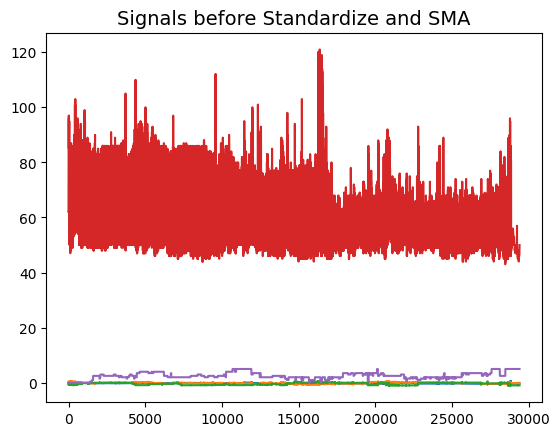

In [ ]:
### START CODE HERE ###
# Before Standardize and SMA
plt.plot(df)
plt.title("Signals before Standardize and SMA", fontsize=14)
plt.show()
### END CODE HERE ###

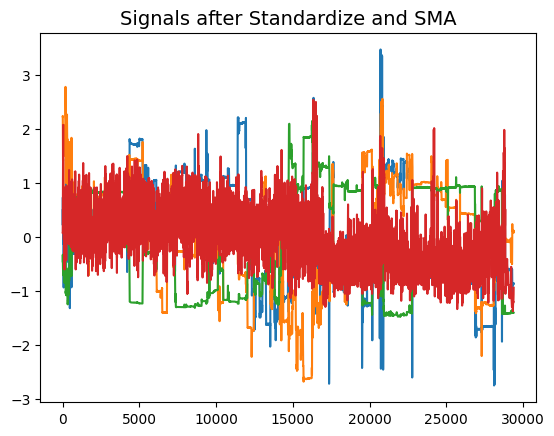

In [ ]:
# After
plt.plot(df_feature_SMA)
plt.title("Signals after Standardize and SMA", fontsize=14)
plt.show()

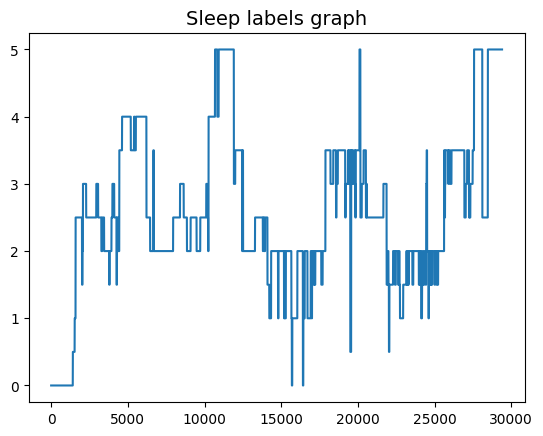

In [ ]:
# Graph Sleep labels
plt.plot(df_label)
plt.title("Sleep labels graph", fontsize=14)
plt.show()

### **Model Experimentaion**

**Train Test Data Preparation**

In [ ]:
X = df_feature_SMA
y = df_label

In [ ]:
y_onehot = pd.get_dummies(y,columns=["sleep"])

In [ ]:
y_onehot

,sleep_0.0,sleep_0.5,sleep_1.0,sleep_1.5,sleep_2.0,sleep_2.5,sleep_3.0,sleep_3.5,sleep_4.0,sleep_5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
29396,0,0,0,0,0,0,0,0,0,1
29397,0,0,0,0,0,0,0,0,0,1
29398,0,0,0,0,0,0,0,0,0,1
29399,0,0,0,0,0,0,0,0,0,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y_onehot, test_size = 0.3, random_state = 42)

##### **Neural Network**
**Create MLP (NN) Model Architecture**

In [ ]:
hiddenL = (50, 50, 50)
act = 'relu'
EP = 1000
lr = 0.001
optimizer = 'adam'
SEED_init = 42
tolr = 1e-4
mlp = MLPClassifier(hidden_layer_sizes=hiddenL, activation=act, max_iter=EP, alpha=lr, solver=optimizer, random_state=SEED_init, tol=tolr, verbose=1)
mlp

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50, 50), max_iter=1000,
              random_state=42, verbose=1)

**Traning MLP (NN) Model**

In [ ]:
mlp.fit(x_train, y_train)

Iteration 1, loss = 3.85858849
Iteration 2, loss = 2.61043018
Iteration 3, loss = 2.37140478
Iteration 4, loss = 2.21043854
Iteration 5, loss = 2.08360432
Iteration 6, loss = 1.99102279
Iteration 7, loss = 1.91859619
Iteration 8, loss = 1.86088377
Iteration 9, loss = 1.81200442
Iteration 10, loss = 1.76767373
Iteration 11, loss = 1.73529012
Iteration 12, loss = 1.69871663
Iteration 13, loss = 1.66932563
Iteration 14, loss = 1.64516741
Iteration 15, loss = 1.62014422
Iteration 16, loss = 1.60317045
Iteration 17, loss = 1.58365427
Iteration 18, loss = 1.56499856
Iteration 19, loss = 1.54504825
Iteration 20, loss = 1.52931274
Iteration 21, loss = 1.51168855
Iteration 22, loss = 1.50114271
Iteration 23, loss = 1.48640303
Iteration 24, loss = 1.47094550
Iteration 25, loss = 1.45908650
Iteration 26, loss = 1.44555364
Iteration 27, loss = 1.43787201
Iteration 28, loss = 1.42452789
Iteration 29, loss = 1.41362730
Iteration 30, loss = 1.40168503
Iteration 31, loss = 1.39368610
Iteration 32, los

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50, 50), max_iter=1000,
              random_state=42, verbose=1)

In [ ]:
import joblib

save model

In [ ]:
# joblib.dump(mlp, "MLP Classifier.pkl")

load model

In [ ]:
# mlp = joblib.load('MLP Classifier.pkl')

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       192
           1       0.86      0.73      0.79      1246
           2       0.77      0.35      0.48      1224
           3       0.84      0.82      0.83      4153
           4       0.64      0.75      0.69       603
           5       0.88      0.88      0.88      1403

   micro avg       0.83      0.74      0.78      8821
   macro avg       0.80      0.71      0.74      8821
weighted avg       0.82      0.74      0.77      8821
 samples avg       0.73      0.74      0.73      8821
```


**MLP (NN) Model Prediction**

In [ ]:
y_pred = mlp.predict(x_test)

In [ ]:
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

**MLP (NN) Model Performance (Confusion Matrix, Classification_report)**


----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       421
           1       0.84      0.68      0.75        62
           2       0.84      0.49      0.62       386
           3       0.53      0.72      0.61       502
           4       0.83      0.86      0.85      2462
           5       0.90      0.76      0.82      1808
           6       0.69      0.37      0.48       672
           7       0.87      0.75      0.81      1191
           8       0.79      0.88      0.83       520
           9       0.88      0.91      0.89       797

   micro avg       0.82      0.77      0.80      8821
   macro avg       0.81      0.73      0.76      8821
weighted avg       0.83      0.77      0.79      8821
 samples avg       0.75      0.77      0.76      8821

Accuracy Score : 0.7322299059063598
----- Confusion matrix of MLP NN predict X_test -----


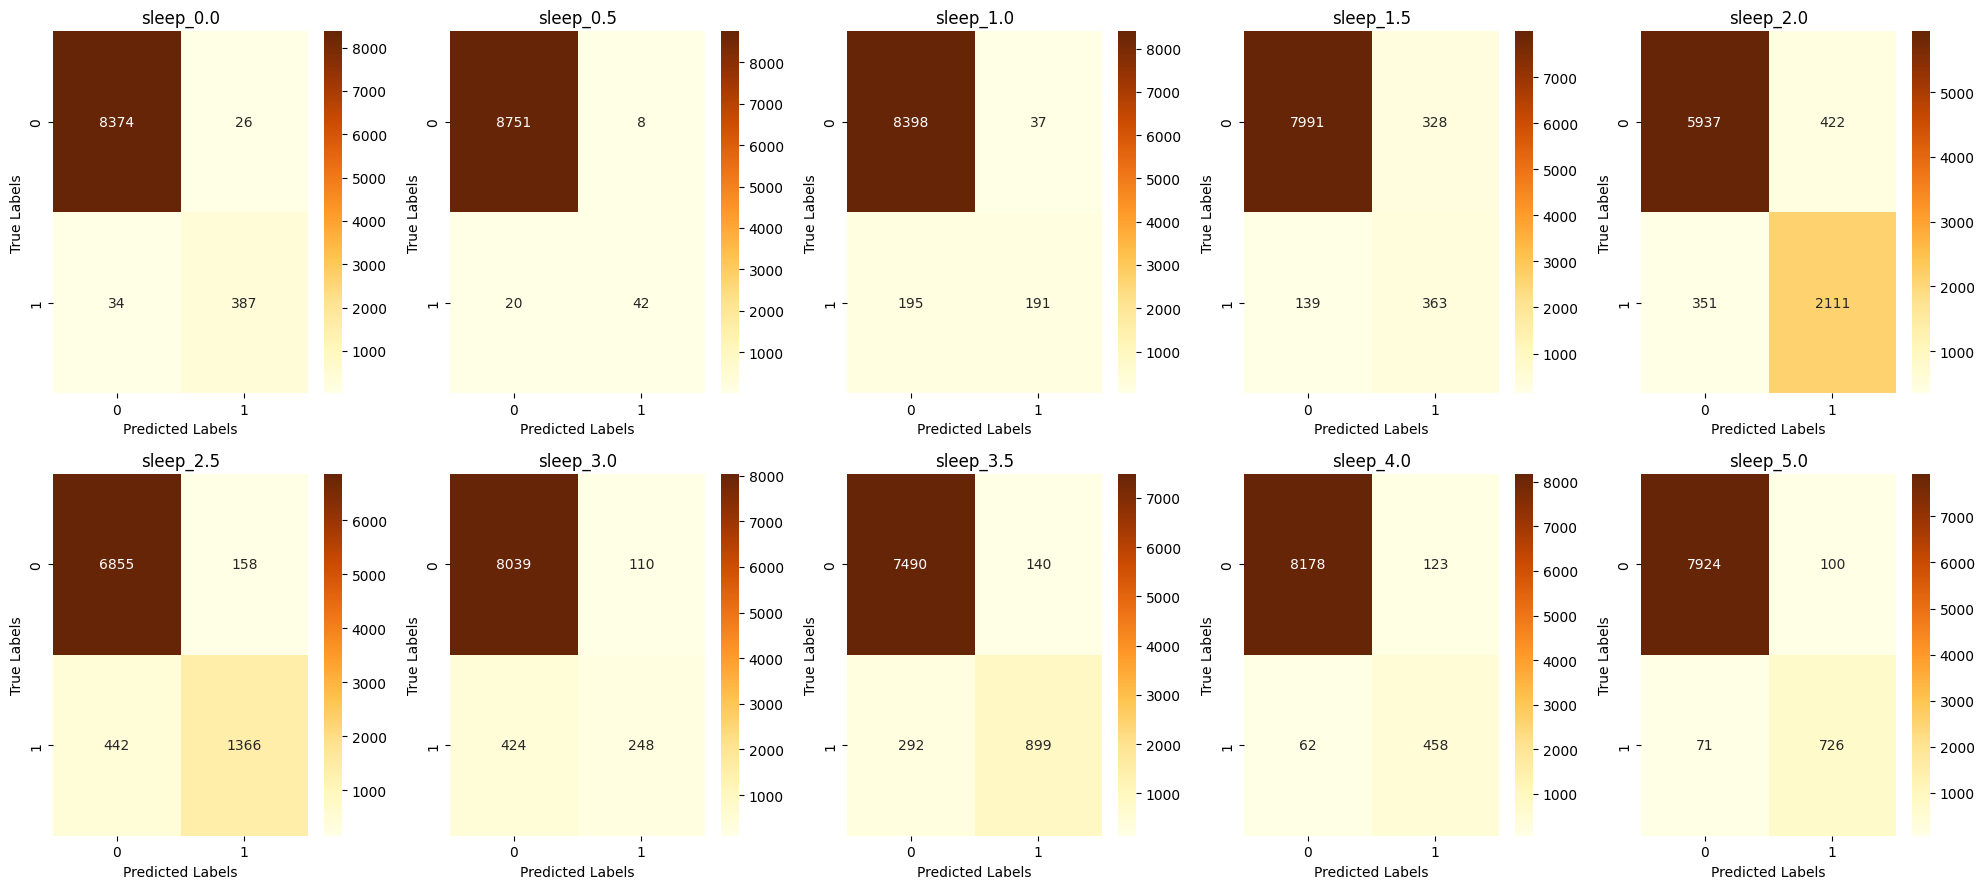

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
print('----- Classification Report of MLP NN predict X_test -----')
print(classification_report(y_test, y_pred, zero_division=0))
print('Accuracy Score : {}'.format(accuracy_score(y_test, y_pred)))
print('----- Confusion matrix of MLP NN predict X_test -----')
multi_cm = multilabel_confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(2, 5, figsize=(20, 9))

for i in range(5):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[0, i], cmap='YlOrBr')
    ax[0, i].set_xlabel('Predicted Labels')
    ax[0, i].set_ylabel('True Labels')
    ax[0, i].set_title(y_pred.columns[i])

for i in range(5, 10):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[1, i-5], cmap='YlOrBr')
    ax[1, i-5].set_xlabel('Predicted Labels')
    ax[1, i-5].set_ylabel('True Labels')
    ax[1, i-5].set_title(y_pred.columns[i])

plt.tight_layout()
plt.show()

##### **Train-Test Data Preparation for CNN Training**
1. Non-Transpose Data (XR Shape1: sliding window size, n_feature)
2. Transpose Data  (XT Shape2: n_feature, sliding window size)

**Non-Transpose data (XR)**



In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ,

X = df_feature_SMA
Y = df_label

XR = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote : mode of labels for whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
yR = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yR
y = pd.get_dummies(yR, columns=['Sleep_Label'])
yR = y

In [ ]:
XR

array([[[[ 0.49633151],
         [ 2.23505065],
         [-0.45123483],
         [ 0.07828446]],

        [[ 0.34336476],
         [ 2.24284367],
         [-0.36885938],
         [ 0.07828446]],

        [[ 0.22009374],
         [ 2.19754425],
         [-0.32853355],
         [ 0.15906364]],

        ...,

        [[-0.41877037],
         [ 1.60333046],
         [-0.73956979],
         [-0.30541667]],

        [[-0.34843415],
         [ 1.60263328],
         [-0.76219255],
         [-0.18828685]],

        [[-0.22990054],
         [ 1.66497519],
         [-0.80233622],
         [ 0.07020654]]],


       [[[ 0.35143713],
         [ 1.71181702],
         [-0.46989206],
         [ 1.07186841]],

        [[ 0.35605885],
         [ 1.60721883],
         [-0.50053775],
         [ 1.17688135]],

        [[ 0.39242707],
         [ 1.53931667],
         [-0.53755832],
         [ 1.25766053]],

        ...,

        [[-0.04298937],
         [ 1.72965682],
         [-0.83555229],
         [ 0.195

In [ ]:
yR

,Sleep_Label_0.0,Sleep_Label_0.5,Sleep_Label_1.0,Sleep_Label_1.5,Sleep_Label_2.0,Sleep_Label_2.5,Sleep_Label_3.0,Sleep_Label_3.5,Sleep_Label_4.0,Sleep_Label_5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2926,0,0,0,0,0,0,0,0,0,1
2927,0,0,0,0,0,0,0,0,0,1
2928,0,0,0,0,0,0,0,0,0,1
2929,0,0,0,0,0,0,0,0,0,1


**Non-Transpose Tran_test_split data**

In [ ]:
#----- CNN with XR -----------
#--- Train - Validate - Test ----
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state=42)
XR_val, XR_test, yR_val, yR_test = train_test_split(XR_test, yR_test, test_size=0.7, random_state=42)

##### **CNN Architecture (XR)**

In [ ]:
CNN_L1 = 32
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yR.shape[1]

pDrop = 0.4

Input_shape = (slidingW, n_feature, 1)
P_size = (2,1)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func, input_shape=Input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 100, 4, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 50, 4, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 50, 4, 32)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 4, 64)         18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 25, 4, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 25, 4, 64)        

##### **Train CNN(XR)**

In [ ]:
historyXR = model.fit(XR_train, yR_train, epochs=100, validation_data=(XR_val, yR_val), verbose=1)

Epoch 1/100
65/65 [==============================] - 3s 10ms/step - loss: 1.7718 - acc: 0.3335 - val_loss: 1.6103 - val_acc: 0.4205
Epoch 2/100
65/65 [==============================] - 0s 6ms/step - loss: 1.3286 - acc: 0.5061 - val_loss: 1.3047 - val_acc: 0.4924
Epoch 3/100
65/65 [==============================] - 0s 5ms/step - loss: 1.1375 - acc: 0.5402 - val_loss: 1.1558 - val_acc: 0.5379
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 0.9971 - acc: 0.5992 - val_loss: 1.0038 - val_acc: 0.6364
Epoch 5/100
65/65 [==============================] - 0s 5ms/step - loss: 0.9091 - acc: 0.6377 - val_loss: 0.9475 - val_acc: 0.5606
Epoch 6/100
65/65 [==============================] - 0s 6ms/step - loss: 0.8351 - acc: 0.6636 - val_loss: 0.9248 - val_acc: 0.6174
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 0.7672 - acc: 0.6758 - val_loss: 0.8282 - val_acc: 0.6364
Epoch 8/100
65/65 [==============================] - 0s 5ms/step - loss: 0.7287 - 

##### **CNN (XR) Performance**

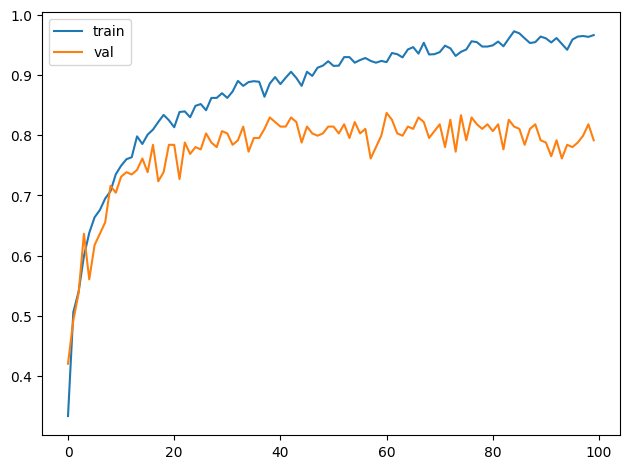

In [ ]:
# summarize history for accuracy
history = historyXR
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

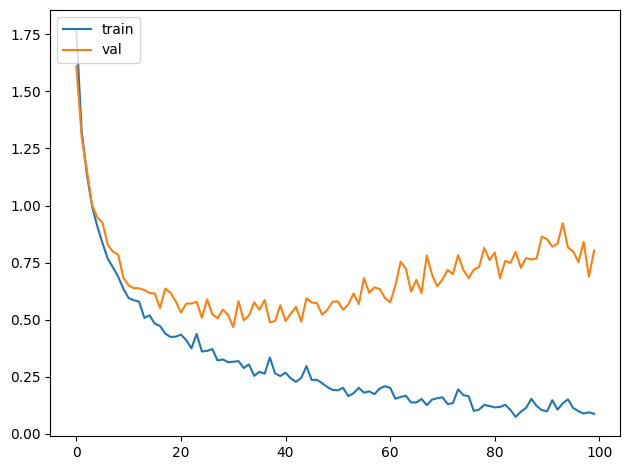

In [ ]:
# summarize history for loss
history=historyXR
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

```
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.92      0.91       125
           2       0.82      0.67      0.74       127
           3       0.87      0.90      0.89       419
           4       0.72      0.76      0.74        58
           5       0.85      0.87      0.86       134

    accuracy                           0.86       880
   macro avg       0.86      0.85      0.86       880
weighted avg       0.86      0.86      0.86       880
```

In [ ]:
CNN_pred = model.predict(XR_test)
CNN_pred_labels = np.argmax(CNN_pred, axis=1)

20/20 [==============================] - 0s 2ms/step


In [ ]:
CNN_pred_labels

array([4, 4, 0, 4, 7, 7, 2, 5, 2, 6, 2, 5, 8, 9, 9, 9, 5, 4, 9, 4, 7, 7,
       0, 5, 4, 4, 4, 5, 3, 4, 2, 4, 4, 7, 4, 5, 3, 4, 6, 4, 5, 5, 5, 4,
       7, 7, 4, 7, 5, 5, 6, 4, 8, 5, 0, 7, 5, 4, 3, 0, 4, 8, 7, 4, 4, 4,
       9, 9, 7, 4, 5, 4, 5, 5, 4, 4, 5, 4, 4, 0, 5, 1, 5, 3, 9, 8, 4, 5,
       4, 8, 4, 2, 4, 4, 7, 6, 5, 4, 3, 7, 5, 9, 0, 6, 5, 8, 5, 6, 9, 0,
       9, 4, 4, 7, 2, 8, 3, 2, 9, 4, 4, 5, 0, 6, 7, 4, 4, 5, 7, 7, 9, 4,
       4, 7, 4, 7, 6, 2, 7, 9, 4, 4, 4, 4, 4, 8, 7, 4, 4, 4, 8, 4, 2, 4,
       4, 4, 5, 4, 9, 8, 5, 4, 0, 6, 5, 8, 5, 5, 0, 9, 5, 4, 9, 7, 4, 7,
       5, 4, 5, 4, 4, 4, 5, 0, 1, 9, 8, 8, 5, 1, 3, 7, 4, 9, 7, 5, 4, 1,
       9, 4, 4, 6, 6, 5, 0, 5, 0, 5, 2, 4, 0, 4, 7, 5, 7, 9, 8, 7, 5, 5,
       2, 6, 2, 5, 1, 5, 6, 4, 5, 8, 2, 4, 5, 9, 6, 7, 7, 8, 5, 4, 4, 4,
       0, 7, 7, 4, 4, 4, 5, 5, 4, 5, 9, 6, 5, 4, 5, 5, 4, 4, 5, 6, 8, 4,
       0, 4, 5, 5, 0, 4, 4, 0, 7, 2, 4, 4, 9, 3, 8, 7, 2, 0, 3, 5, 8, 5,
       4, 7, 7, 4, 4, 5, 4, 7, 2, 5, 9, 8, 5, 7, 7,

In [ ]:
yR_test_labels = np.argmax(yR_test.values, axis=1)

In [ ]:
yR_test_labels

array([4, 4, 0, 4, 7, 9, 4, 5, 2, 4, 2, 5, 8, 7, 9, 9, 5, 4, 9, 4, 7, 4,
       0, 5, 4, 2, 5, 8, 3, 4, 4, 4, 2, 7, 4, 5, 4, 4, 5, 4, 8, 5, 5, 4,
       7, 7, 4, 7, 5, 5, 6, 4, 8, 5, 0, 6, 6, 4, 3, 0, 5, 8, 7, 4, 4, 4,
       9, 9, 7, 7, 4, 5, 5, 5, 4, 4, 5, 3, 3, 0, 5, 2, 5, 3, 9, 7, 4, 5,
       4, 8, 4, 4, 2, 4, 7, 5, 5, 4, 3, 7, 5, 9, 0, 9, 6, 8, 5, 6, 9, 0,
       9, 4, 4, 7, 2, 8, 4, 2, 9, 4, 4, 5, 0, 5, 7, 4, 3, 6, 7, 7, 9, 4,
       4, 7, 4, 7, 6, 2, 7, 9, 4, 4, 4, 4, 4, 8, 7, 3, 3, 4, 4, 4, 4, 3,
       4, 4, 5, 5, 9, 8, 5, 4, 0, 6, 5, 8, 6, 5, 0, 9, 6, 2, 9, 7, 4, 7,
       5, 3, 5, 3, 4, 4, 6, 0, 1, 9, 7, 9, 5, 1, 4, 7, 4, 9, 7, 5, 4, 1,
       9, 4, 4, 6, 6, 5, 0, 5, 0, 5, 2, 4, 0, 4, 7, 5, 7, 7, 9, 7, 5, 5,
       2, 6, 2, 5, 1, 6, 6, 4, 5, 8, 2, 4, 5, 7, 5, 7, 7, 9, 5, 4, 5, 4,
       0, 7, 7, 4, 4, 4, 5, 5, 4, 5, 9, 4, 5, 4, 5, 5, 4, 4, 5, 6, 7, 4,
       0, 4, 5, 5, 0, 4, 4, 0, 7, 2, 4, 4, 9, 3, 8, 5, 2, 0, 4, 4, 4, 5,
       4, 7, 7, 4, 4, 6, 4, 9, 4, 5, 9, 8, 3, 7, 7,

----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.80      1.00      0.89         4
           2       0.65      0.76      0.70        29
           3       0.57      0.41      0.47        32
           4       0.81      0.76      0.79       178
           5       0.79      0.89      0.83       124
           6       0.58      0.48      0.52        46
           7       0.85      0.82      0.83        88
           8       0.64      0.91      0.75        32
           9       0.88      0.80      0.84        55

    accuracy                           0.78       616
   macro avg       0.76      0.78      0.76       616
weighted avg       0.78      0.78      0.78       616

----- Confusion matrix of CNN predict X_test -----


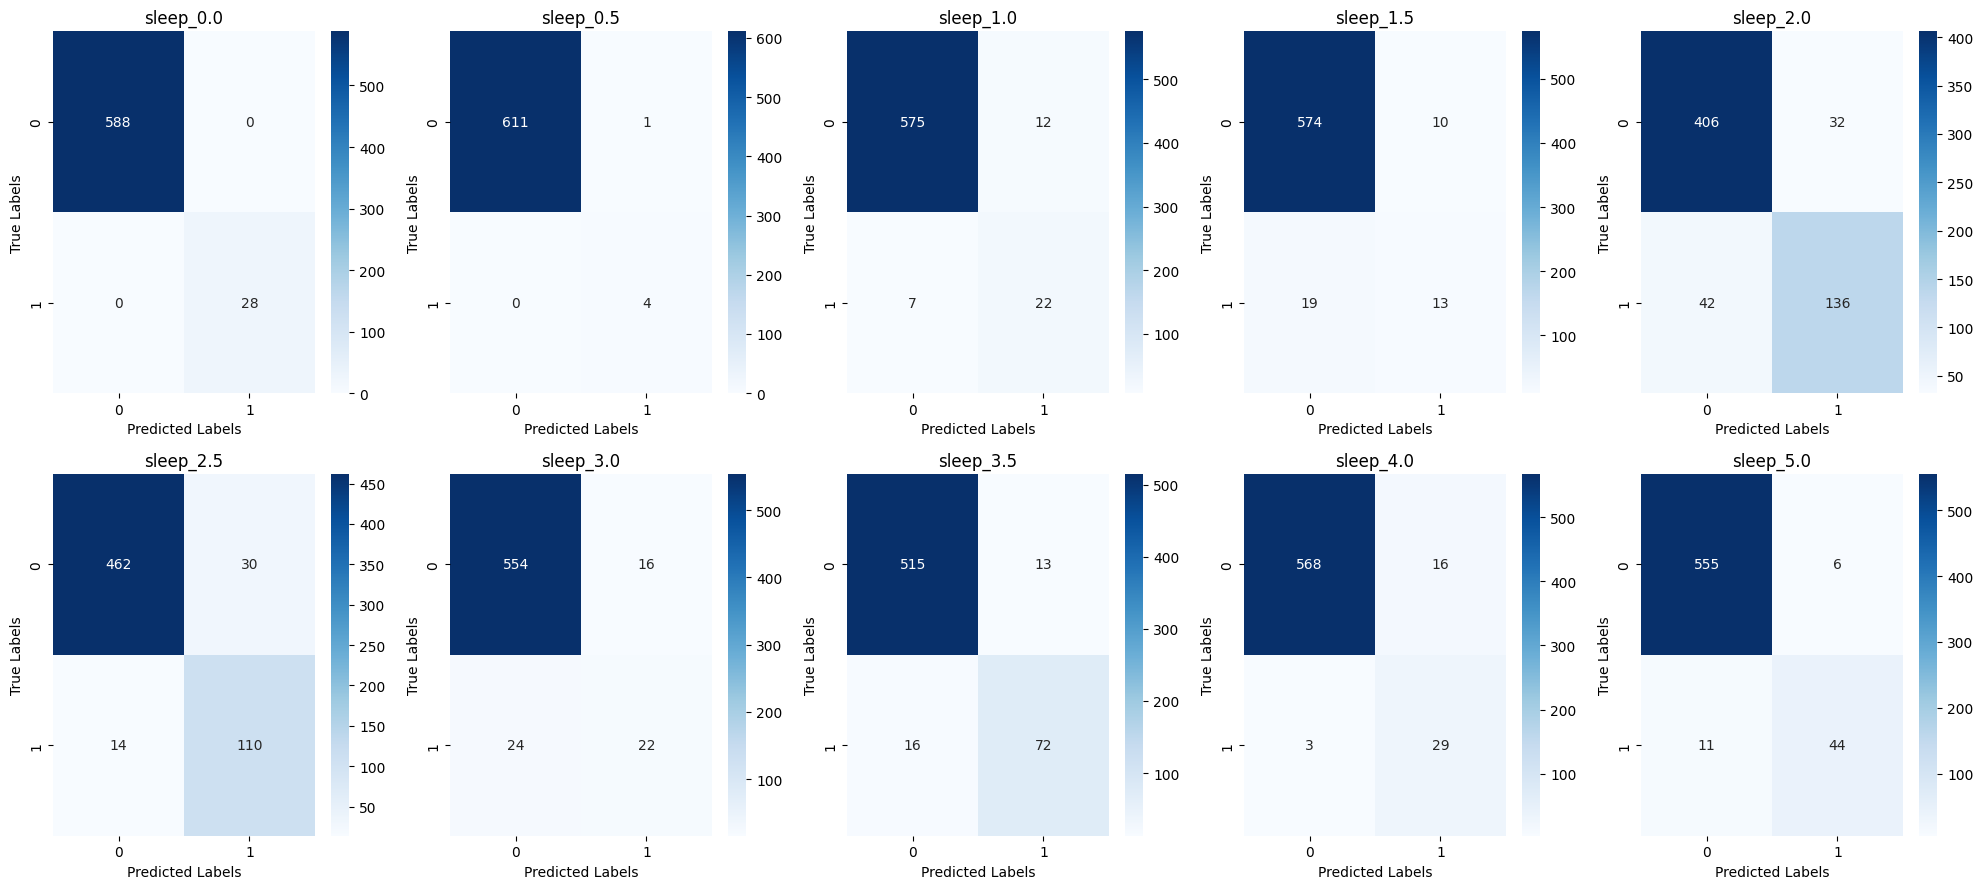

In [ ]:
print('----- Classification Report of CNN predict X_test -----')
print(classification_report(yR_test_labels, CNN_pred_labels, zero_division=0))
print('----- Confusion matrix of CNN predict X_test -----')
multi_cm = multilabel_confusion_matrix(yR_test_labels, CNN_pred_labels)
f, ax = plt.subplots(2, 5, figsize=(20, 9))

for i in range(5):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[0, i], cmap='Blues')
    ax[0, i].set_xlabel('Predicted Labels')
    ax[0, i].set_ylabel('True Labels')
    ax[0, i].set_title(y_pred.columns[i])

for i in range(5, 10):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[1, i-5], cmap='Blues')
    ax[1, i-5].set_xlabel('Predicted Labels')
    ax[1, i-5].set_ylabel('True Labels')
    ax[1, i-5].set_title(y_pred.columns[i])

plt.tight_layout()
plt.show()

### **Transpose data (XT)**

In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA
Y = df_label

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = np.array(X.iloc[i: i+slidingW])
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW, 1)
    # label sliding windows = df_label[i:i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
yT = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(yT, columns=['Sleep_Label'])
yT = y

In [ ]:
XT

array([[[[ 0.49633151],
         [ 0.34336476],
         [ 0.22009374],
         ...,
         [-0.41877037],
         [-0.34843415],
         [-0.22990054]],

        [[ 2.23505065],
         [ 2.24284367],
         [ 2.19754425],
         ...,
         [ 1.60333046],
         [ 1.60263328],
         [ 1.66497519]],

        [[-0.45123483],
         [-0.36885938],
         [-0.32853355],
         ...,
         [-0.73956979],
         [-0.76219255],
         [-0.80233622]],

        [[ 0.07828446],
         [ 0.07828446],
         [ 0.15906364],
         ...,
         [-0.30541667],
         [-0.18828685],
         [ 0.07020654]]],


       [[[ 0.35143713],
         [ 0.35605885],
         [ 0.39242707],
         ...,
         [-0.04298937],
         [-0.03217253],
         [-0.0257048 ]],

        [[ 1.71181702],
         [ 1.60721883],
         [ 1.53931667],
         ...,
         [ 1.72965682],
         [ 1.72879477],
         [ 1.72736124]],

        [[-0.46989206],
         [-0.5

In [ ]:
yT

,Sleep_Label_0.0,Sleep_Label_0.5,Sleep_Label_1.0,Sleep_Label_1.5,Sleep_Label_2.0,Sleep_Label_2.5,Sleep_Label_3.0,Sleep_Label_3.5,Sleep_Label_4.0,Sleep_Label_5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2926,0,0,0,0,0,0,0,0,0,1
2927,0,0,0,0,0,0,0,0,0,1
2928,0,0,0,0,0,0,0,0,0,1
2929,0,0,0,0,0,0,0,0,0,1


##### **Train Test Split (XT)**

In [ ]:
#----- CNN with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=42)
XT_val, XT_test, yT_val, yT_test = train_test_split(XT_test, yT_test, test_size=0.7, random_state=42)

##### **CNN Architecture (XT)**

In [ ]:
CNN_L1 = 32
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yT.shape[1]
print(Nclass)

Input_shape = (n_feature, slidingW, 1)
P_size = (1,2)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func, input_shape=Input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])
model.summary()

10
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 4, 100, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 4, 50, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 4, 50, 32)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 50, 64)         18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 4, 25, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 4, 25, 64)    

##### **Train CNN (XT)**

In [ ]:
historyXT = model.fit(XT_train, yT_train, epochs=100, validation_data=(XT_val, yT_val), verbose=1)

Epoch 1/100
65/65 [==============================] - 5s 16ms/step - loss: 1.7538 - acc: 0.3389 - val_loss: 1.5733 - val_acc: 0.4242
Epoch 2/100
65/65 [==============================] - 1s 8ms/step - loss: 1.3245 - acc: 0.4905 - val_loss: 1.2972 - val_acc: 0.4924
Epoch 3/100
65/65 [==============================] - 1s 9ms/step - loss: 1.1414 - acc: 0.5456 - val_loss: 1.1885 - val_acc: 0.5379
Epoch 4/100
65/65 [==============================] - 1s 9ms/step - loss: 0.9808 - acc: 0.6051 - val_loss: 1.0112 - val_acc: 0.6174
Epoch 5/100
65/65 [==============================] - 1s 9ms/step - loss: 0.8950 - acc: 0.6485 - val_loss: 0.8964 - val_acc: 0.6970
Epoch 6/100
65/65 [==============================] - 1s 9ms/step - loss: 0.8111 - acc: 0.6689 - val_loss: 0.8986 - val_acc: 0.6477
Epoch 7/100
65/65 [==============================] - 1s 9ms/step - loss: 0.7804 - acc: 0.6694 - val_loss: 0.7986 - val_acc: 0.7045
Epoch 8/100
65/65 [==============================] - 1s 8ms/step - loss: 0.6888 - 

##### **CNN Performance (XT)**

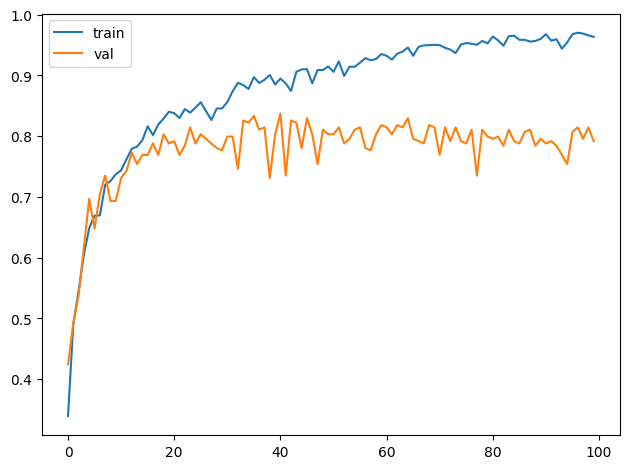

In [ ]:
# summarize history for accuracy
history = historyXT
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

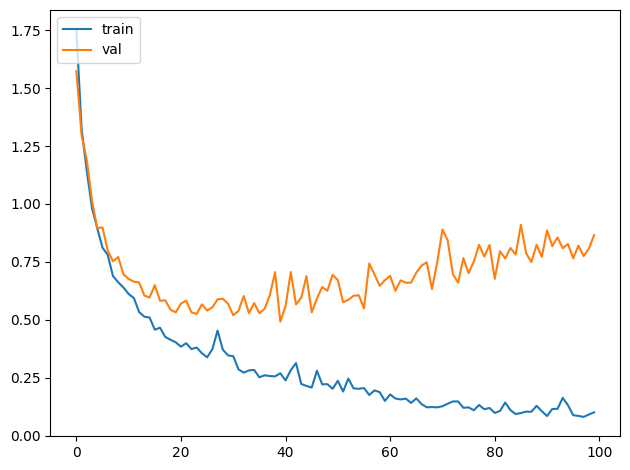

In [ ]:
# summarize history for loss
history = historyXT
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

```
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.88      0.88      0.88       125
           2       0.76      0.54      0.63       127
           3       0.83      0.89      0.86       419
           4       0.72      0.67      0.70        58
           5       0.82      0.90      0.86       134

    accuracy                           0.82       880
   macro avg       0.83      0.80      0.81       880
weighted avg       0.82      0.82      0.82       880
```

In [ ]:
CNN_pred = model.predict(XT_test)
CNN_pred_labels = np.argmax(CNN_pred, axis=1)

20/20 [==============================] - 0s 3ms/step


In [ ]:
yT_test_labels = np.argmax(yT_test.values, axis=1)

----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.80      1.00      0.89         4
           2       0.66      0.72      0.69        29
           3       0.65      0.53      0.59        32
           4       0.81      0.81      0.81       178
           5       0.79      0.90      0.85       124
           6       0.53      0.41      0.46        46
           7       0.85      0.80      0.82        88
           8       0.77      0.84      0.81        32
           9       0.90      0.84      0.87        55

    accuracy                           0.79       616
   macro avg       0.78      0.79      0.78       616
weighted avg       0.79      0.79      0.79       616

----- Confusion matrix of CNN predict X_test -----


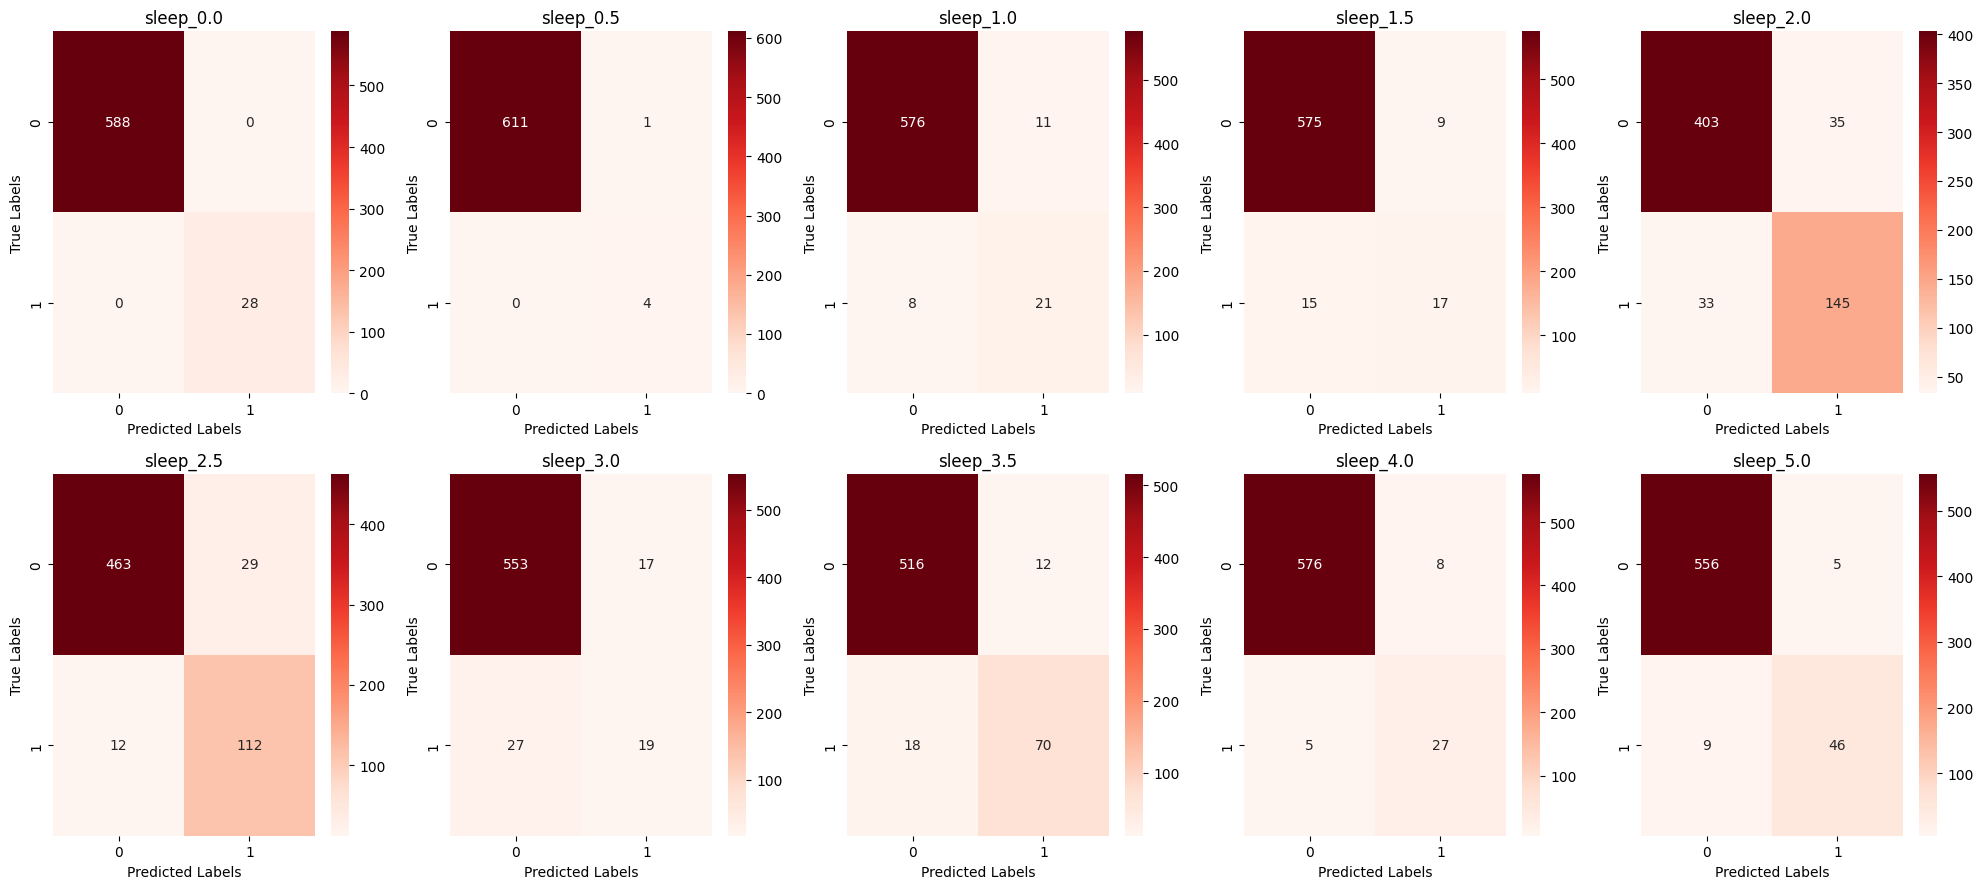

In [ ]:
print('----- Classification Report of CNN predict X_test -----')
print(classification_report(yT_test_labels, CNN_pred_labels, zero_division=0))
print('----- Confusion matrix of CNN predict X_test -----')
multi_cm = multilabel_confusion_matrix(yT_test_labels, CNN_pred_labels)
f, ax = plt.subplots(2, 5, figsize=(20, 9))

for i in range(5):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[0, i], cmap='Reds')
    ax[0, i].set_xlabel('Predicted Labels')
    ax[0, i].set_ylabel('True Labels')
    ax[0, i].set_title(y_pred.columns[i])

for i in range(5, 10):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[1, i-5], cmap='Reds')
    ax[1, i-5].set_xlabel('Predicted Labels')
    ax[1, i-5].set_ylabel('True Labels')
    ax[1, i-5].set_title(y_pred.columns[i])

plt.tight_layout()
plt.show()

### **Long Short Term Memory (LSTM)**

**Train-Test Data Preparation**
LSTM Use data XR, XT same as CNN

##### **Prepare (XR) Data**

In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ,

X = df_feature_SMA
Y = df_label

XR = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote : mode of labels for whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
yR = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yR
y = pd.get_dummies(yR, columns=['Sleep_Label'])
yR = y

In [ ]:
#--- Train - Validate - Test ----
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state=42)
XR_val, XR_test, yR_val, yR_test = train_test_split(XR_test, yR_test, test_size=0.7, random_state=42)

##### **LSTM (XR) Model Architecture**

In [ ]:
#LSTM 2 Layers
#Nodes = [50, 100, 150, 200, 250, 300, 400, 500, 1000]
n_hidden1 = 1000
n_hidden2 = 500

Nclass = yR.shape[1]
Input_shape = (slidingW, n_feature)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(0.25))

model.add(LSTM(n_hidden2))
model.add(Dropout(0.5))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 1000)         4020000   
                                                                 
 dropout_37 (Dropout)        (None, 100, 1000)         0         
                                                                 
 lstm_5 (LSTM)               (None, 500)               3002000   
                                                                 
 dropout_38 (Dropout)        (None, 500)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                5010      
                                                                 
Total params: 7027010 (26.81 MB)
Trainable params: 7027010 (26.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [ ]:
# Compiling the model
#adam = optimizers.Adam(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])

##### **Training LSTM (XR) Model**

In [ ]:
# Training the model
EP = 200
batch_size = 32

historyL_XR = model.fit(XR_train, yR_train, batch_size=batch_size, epochs=EP, validation_data=(XR_val, yR_val), verbose=1)

Epoch 1/200
65/65 [==============================] - 7s 44ms/step - loss: 1.7985 - acc: 0.3150 - val_loss: 1.6979 - val_acc: 0.3447
Epoch 2/200
65/65 [==============================] - 2s 32ms/step - loss: 1.6139 - acc: 0.3642 - val_loss: 1.6673 - val_acc: 0.4129
Epoch 3/200
65/65 [==============================] - 2s 34ms/step - loss: 1.6473 - acc: 0.3788 - val_loss: 1.7817 - val_acc: 0.3674
Epoch 4/200
65/65 [==============================] - 2s 33ms/step - loss: 1.7424 - acc: 0.3320 - val_loss: 1.6603 - val_acc: 0.3598
Epoch 5/200
65/65 [==============================] - 2s 31ms/step - loss: 1.5658 - acc: 0.3944 - val_loss: 1.7175 - val_acc: 0.3409
Epoch 6/200
65/65 [==============================] - 2s 30ms/step - loss: 1.5284 - acc: 0.4066 - val_loss: 1.4827 - val_acc: 0.4621
Epoch 7/200
65/65 [==============================] - 2s 30ms/step - loss: 1.4925 - acc: 0.4086 - val_loss: 1.5066 - val_acc: 0.4508
Epoch 8/200
65/65 [==============================] - 2s 30ms/step - loss: 1.

 **LSTM (XR) Model Performance**


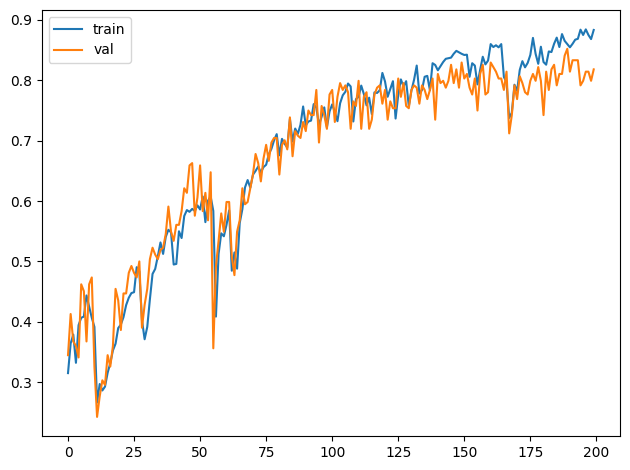

In [ ]:
# summarize history for accuracy
history = historyL_XR
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

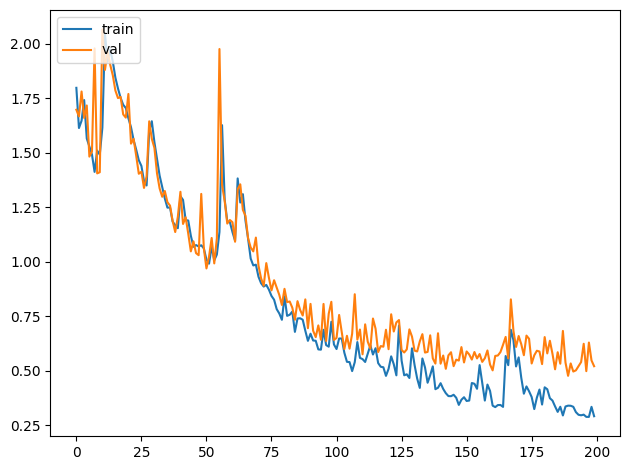

In [ ]:
# summarize history for loss
history = historyL_XR
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

```
             precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.80      0.72      0.76       125
           2       0.49      0.28      0.36       127
           3       0.72      0.86      0.79       419
           4       0.00      0.00      0.00        58
           5       0.65      0.85      0.74       134

    accuracy                           0.70       880
   macro avg       0.60      0.61      0.60       880
weighted avg       0.65      0.70      0.66       880

```

In [ ]:
LSTM_pred = model.predict(XR_test)

20/20 [==============================] - 1s 12ms/step


In [ ]:
LSTM_pred_labels = np.argmax(LSTM_pred, axis=1)
yR_test_labels = np.argmax(yR_test.values, axis=1)

----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.67      1.00      0.80         4
           2       0.74      0.79      0.77        29
           3       0.54      0.22      0.31        32
           4       0.81      0.88      0.84       178
           5       0.83      0.82      0.83       124
           6       0.65      0.48      0.55        46
           7       0.87      0.83      0.85        88
           8       0.77      0.94      0.85        32
           9       0.80      0.95      0.87        55

    accuracy                           0.81       616
   macro avg       0.77      0.79      0.77       616
weighted avg       0.80      0.81      0.80       616

----- Confusion matrix of CNN predict X_test -----


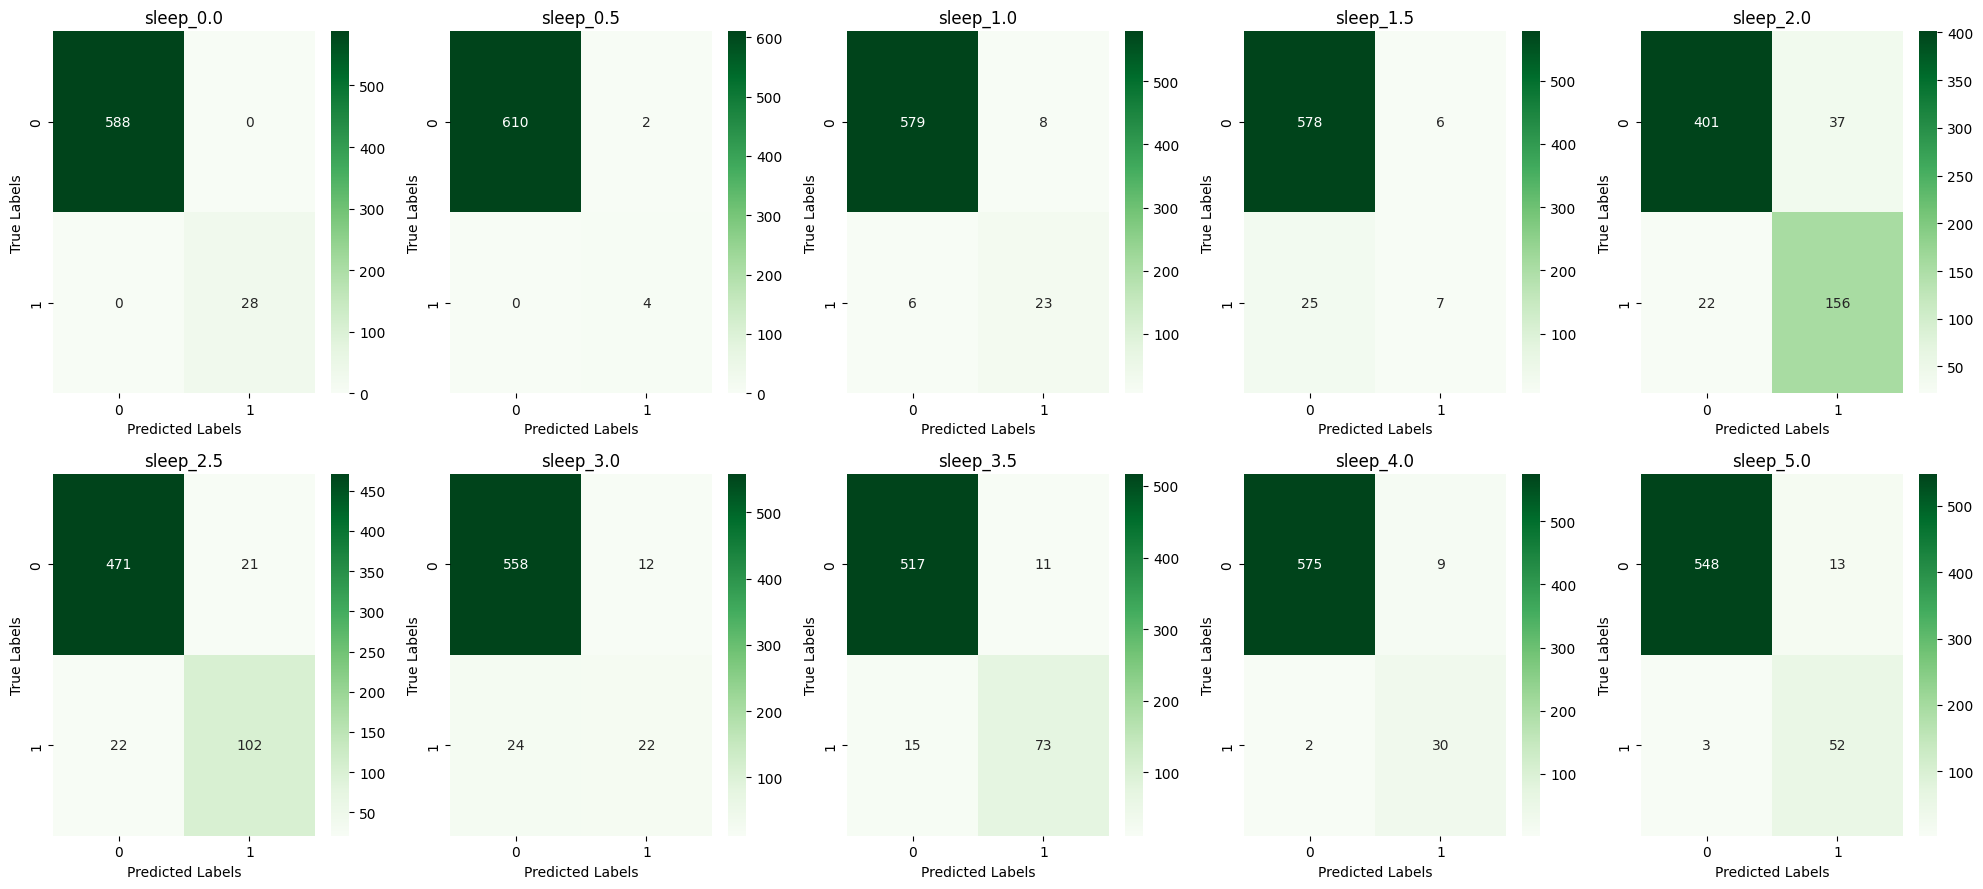

In [ ]:
print('----- Classification Report of CNN predict X_test -----')
print(classification_report(yR_test_labels, LSTM_pred_labels, zero_division=0))
print('----- Confusion matrix of CNN predict X_test -----')
multi_cm = multilabel_confusion_matrix(yR_test_labels, LSTM_pred_labels)
f, ax = plt.subplots(2, 5, figsize=(20, 9))

for i in range(5):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[0, i], cmap='Greens')
    ax[0, i].set_xlabel('Predicted Labels')
    ax[0, i].set_ylabel('True Labels')
    ax[0, i].set_title(y_pred.columns[i])

for i in range(5, 10):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[1, i-5], cmap='Greens')
    ax[1, i-5].set_xlabel('Predicted Labels')
    ax[1, i-5].set_ylabel('True Labels')
    ax[1, i-5].set_title(y_pred.columns[i])

plt.tight_layout()
plt.show()

##### **Prepare (XT) Data**

In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA
Y = df_label

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = np.array(X.iloc[i: i+slidingW])
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW, 1)
    # label sliding windows = df_label[i:i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
yT = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(yT, columns=['Sleep_Label'])
yT = y

In [ ]:
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=42)
XT_val, XT_test, yT_val, yT_test = train_test_split(XT_test, yT_test, test_size=0.7, random_state=42)

##### **Create LSTM (XT) Model Architecture**

In [ ]:
#LSTM 2 Layers
#Nodes = [50, 100, 150, 200, 250, 300, 400, 500, 1000]
n_hidden1 = 400
n_hidden2 = 300

Nclass = yT.shape[1]
Input_shape = (n_feature, slidingW)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(0.25))

model.add(LSTM(n_hidden2))
model.add(Dropout(0.5))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 400)            801600    
                                                                 
 dropout_41 (Dropout)        (None, 4, 400)            0         
                                                                 
 lstm_9 (LSTM)               (None, 300)               841200    
                                                                 
 dropout_42 (Dropout)        (None, 300)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                3010      
                                                                 
Total params: 1645810 (6.28 MB)
Trainable params: 1645810 (6.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [ ]:
# Compiling the model
#adam = optimizers.Adam(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])

In [ ]:
# Training the model
EP = 100
batch_size = 32

historyL_XT = model.fit(XT_train, yT_train, batch_size=batch_size, epochs=EP, validation_data=(XT_val, yT_val), verbose=1)

Epoch 1/100
65/65 [==============================] - 5s 19ms/step - loss: 1.8298 - acc: 0.3281 - val_loss: 1.6453 - val_acc: 0.4167
Epoch 2/100
65/65 [==============================] - 1s 8ms/step - loss: 1.4184 - acc: 0.4817 - val_loss: 1.4606 - val_acc: 0.4432
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 1.2560 - acc: 0.5144 - val_loss: 1.2618 - val_acc: 0.5303
Epoch 4/100
65/65 [==============================] - 1s 9ms/step - loss: 1.0814 - acc: 0.5588 - val_loss: 1.0446 - val_acc: 0.6098
Epoch 5/100
65/65 [==============================] - 1s 10ms/step - loss: 0.9473 - acc: 0.6246 - val_loss: 0.9746 - val_acc: 0.6250
Epoch 6/100
65/65 [==============================] - 1s 10ms/step - loss: 0.8908 - acc: 0.6441 - val_loss: 0.8871 - val_acc: 0.6591
Epoch 7/100
65/65 [==============================] - 1s 10ms/step - loss: 0.7785 - acc: 0.6909 - val_loss: 0.8698 - val_acc: 0.6553
Epoch 8/100
65/65 [==============================] - 1s 14ms/step - loss: 0.750

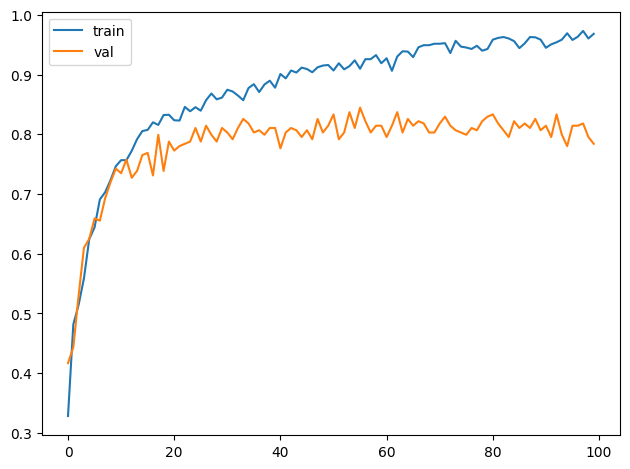

In [ ]:
# summarize history for accuracy
history = historyL_XT
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

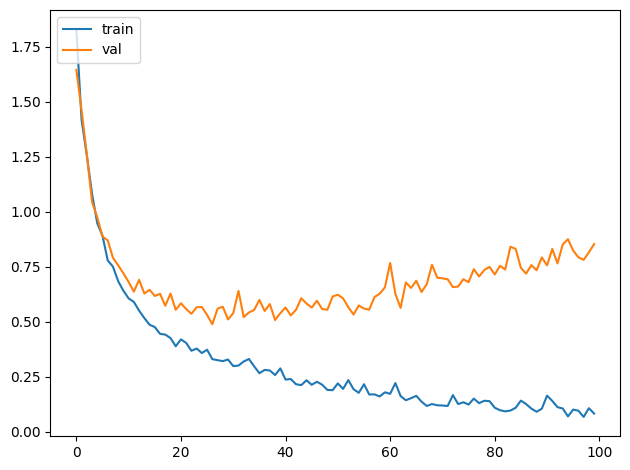

In [ ]:
# summarize history for loss
history = historyL_XT
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
LSTM_pred = model.predict(XT_test)

20/20 [==============================] - 1s 3ms/step


In [ ]:
LSTM_pred_labels = np.argmax(LSTM_pred, axis=1)
yT_test_labels = np.argmax(yT_test.values, axis=1)

----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.80      1.00      0.89         4
           2       0.63      0.59      0.61        29
           3       0.47      0.66      0.55        32
           4       0.85      0.72      0.78       178
           5       0.77      0.85      0.81       124
           6       0.59      0.50      0.54        46
           7       0.81      0.83      0.82        88
           8       0.76      0.78      0.77        32
           9       0.84      0.85      0.85        55

    accuracy                           0.77       616
   macro avg       0.74      0.78      0.76       616
weighted avg       0.77      0.77      0.77       616

----- Confusion matrix of CNN predict X_test -----


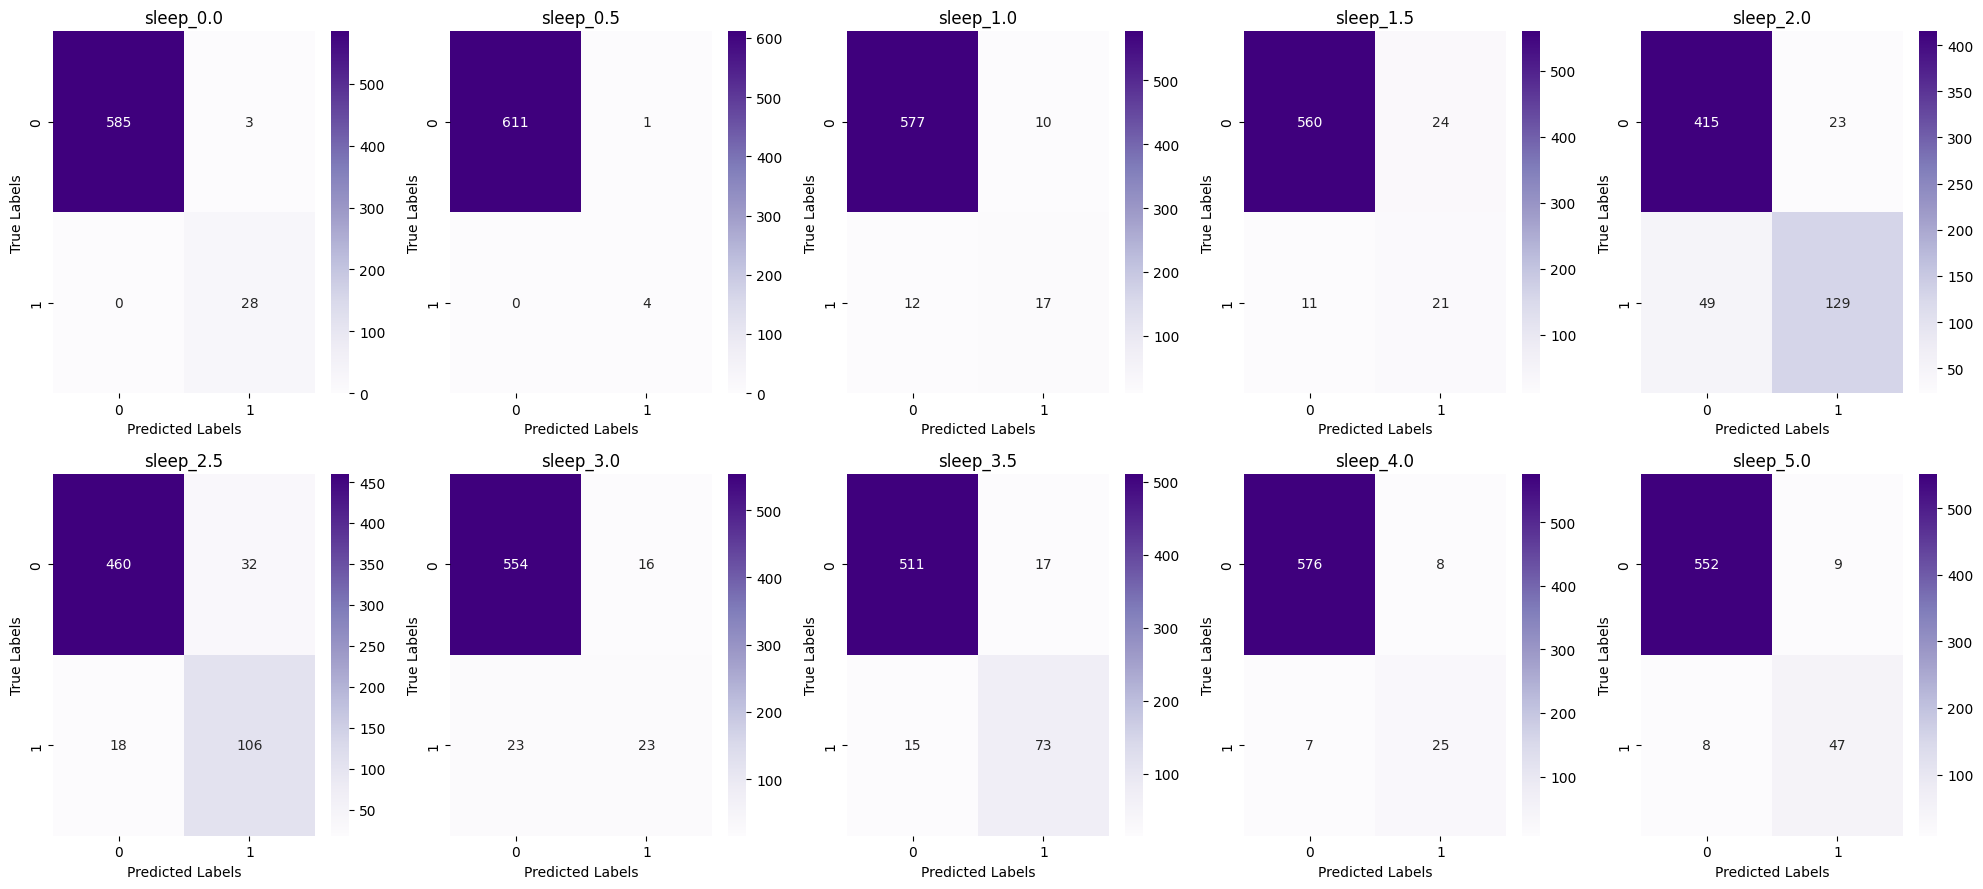

In [ ]:
print('----- Classification Report of CNN predict X_test -----')
print(classification_report(yT_test_labels, LSTM_pred_labels, zero_division=0))
print('----- Confusion matrix of CNN predict X_test -----')
multi_cm = multilabel_confusion_matrix(yT_test_labels, LSTM_pred_labels)
f, ax = plt.subplots(2, 5, figsize=(20, 9))

for i in range(5):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[0, i], cmap='Purples')
    ax[0, i].set_xlabel('Predicted Labels')
    ax[0, i].set_ylabel('True Labels')
    ax[0, i].set_title(y_pred.columns[i])

for i in range(5, 10):
    sns.heatmap(multi_cm[i], annot=True, fmt='d', ax=ax[1, i-5], cmap='Purples')
    ax[1, i-5].set_xlabel('Predicted Labels')
    ax[1, i-5].set_ylabel('True Labels')
    ax[1, i-5].set_title(y_pred.columns[i])

plt.tight_layout()
plt.show()